# Chicken Weights by Feed Type

## Dataset

Newly hatched chicks were randomly allocated into six groups, and each group was given a different feed supplement. Their weights in grams after six weeks are given along with feed types.

*Source: Anonymous (1948) Biometrika, 35, 214.*

## Questions to Answer

We want to know: 1) is there a significant difference in weights amongst the various feed types; and, 2) if so, what is the probability that a specific feed type will outperform other feed types.

## Summary

Newly hatched chicks were randomly allocated into six groups, and each group was given a different feed supplement. Their weights in grams after six weeks are given along with feed types.

The response variable is `weight` and the independent variable `feed` is a factor with 6 levels: casein, horsebean, linseed, meatmeal, soybean, and sunflower. There are a total of 71 observations, with 10-14 observations per factor. For this analysis, we'll create a new variable `feed_name` and convert `feed` to a numeric.

Plotting the distributions of weight by feed_name shows some difference across the feed types, with casein and sunflower appearing associated with higher weight.  The sunflower weights appear tightly distributed, with a few outliers. Given the sample size, it's unclear if these are true outliers as the casein group seems to have a similar variance.

## Required Packages

In [1]:
library(tidyverse)
library(rjags)
library(glue)

source("funcs.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs



## Data

Newly hatched chicks were randomly allocated into six groups, and each group was given a different feed supplement. Their weights in grams after six weeks are given along with feed types.

The response variable is `weight` and the independent variable `feed` is a factor with 6 levels: casein, horsebean, linseed, meatmeal, soybean, and sunflower. There are a total of 71 observations, with 10-14 observations per factor. For this analysis, we'll create a new variable `feed_name` and convert `feed` to a numeric.

Plotting the distributions of weight by feed_name shows some difference across the feed types, with casein and sunflower appearing associated with higher weight.  The sunflower weights appear tightly distributed, with a few outliers. Given the sample size, it's unclear if these are true outliers as the casein group seems to have a similar variance.

In [2]:
data = datasets::chickwts %>%
  mutate(
    feed_name = feed,
    feed = as.numeric(feed)
    )

In [3]:
str(data)

'data.frame':	71 obs. of  3 variables:
 $ weight   : num  179 160 136 227 217 168 108 124 143 140 ...
 $ feed     : num  2 2 2 2 2 2 2 2 2 2 ...
 $ feed_name: Factor w/ 6 levels "casein","horsebean",..: 2 2 2 2 2 2 2 2 2 2 ...


In [4]:
head(data)

,weight,feed,feed_name
,<dbl>,<dbl>,<fct>
1,179,2,horsebean
2,160,2,horsebean
3,136,2,horsebean
4,227,2,horsebean
5,217,2,horsebean
6,168,2,horsebean


In [5]:
table(data$feed_name)


   casein horsebean   linseed  meatmeal   soybean sunflower 
       12        10        12        11        14        12 

### Distribution of Weights by Feed Type

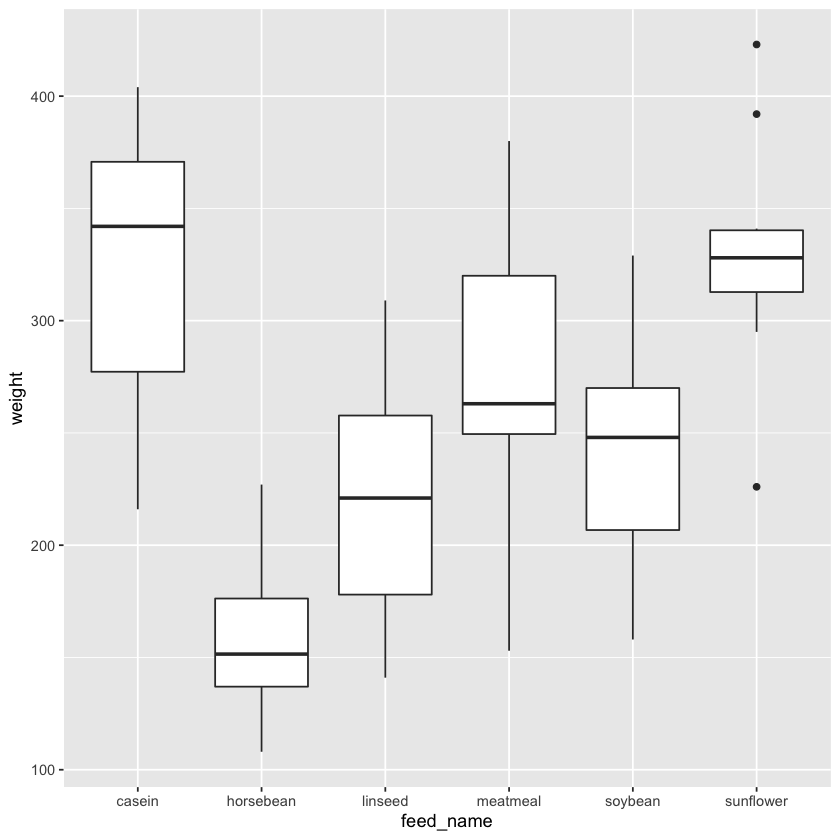

In [6]:
ggplot(data, aes(x=feed_name, y=weight, group=feed_name)) +
  geom_boxplot()

In [7]:
data %>%
    filter(feed_name=="sunflower")

weight,feed,feed_name
<dbl>,<dbl>,<fct>
423,6,sunflower
340,6,sunflower
392,6,sunflower
339,6,sunflower
341,6,sunflower
226,6,sunflower
320,6,sunflower
295,6,sunflower
334,6,sunflower


## Models

### Base Linear Model

We'll user a linear model as a base, and fit without an intercept for easy interpretation and comparison with other methods. Our results mirror the boxplots-- casein and sunflower feeds appear associated with higher weights, but there doesn't seem to be a clear winner amongst the top two. The residuals don't show a clear pattern.

Before analysis, we'll shuffle the dataset so that the observations are not grouped by factor order. 

In [8]:
set.seed(43)
idx = sample(c(1:nrow(data)), nrow(data))
data = data[idx,]

In [9]:
mod.base = lm(weight ~ feed_name + 0, data=data)
summary(mod.base)


Call:
lm(formula = weight ~ feed_name + 0, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-123.909  -34.413    1.571   38.170  103.091 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
feed_namecasein      323.58      15.83  20.436  < 2e-16 ***
feed_namehorsebean   160.20      17.35   9.236 1.91e-13 ***
feed_namelinseed     218.75      15.83  13.815  < 2e-16 ***
feed_namemeatmeal    276.91      16.54  16.744  < 2e-16 ***
feed_namesoybean     246.43      14.66  16.810  < 2e-16 ***
feed_namesunflower   328.92      15.83  20.773  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 54.85 on 65 degrees of freedom
Multiple R-squared:  0.9629,	Adjusted R-squared:  0.9595 
F-statistic: 281.4 on 6 and 65 DF,  p-value: < 2.2e-16


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



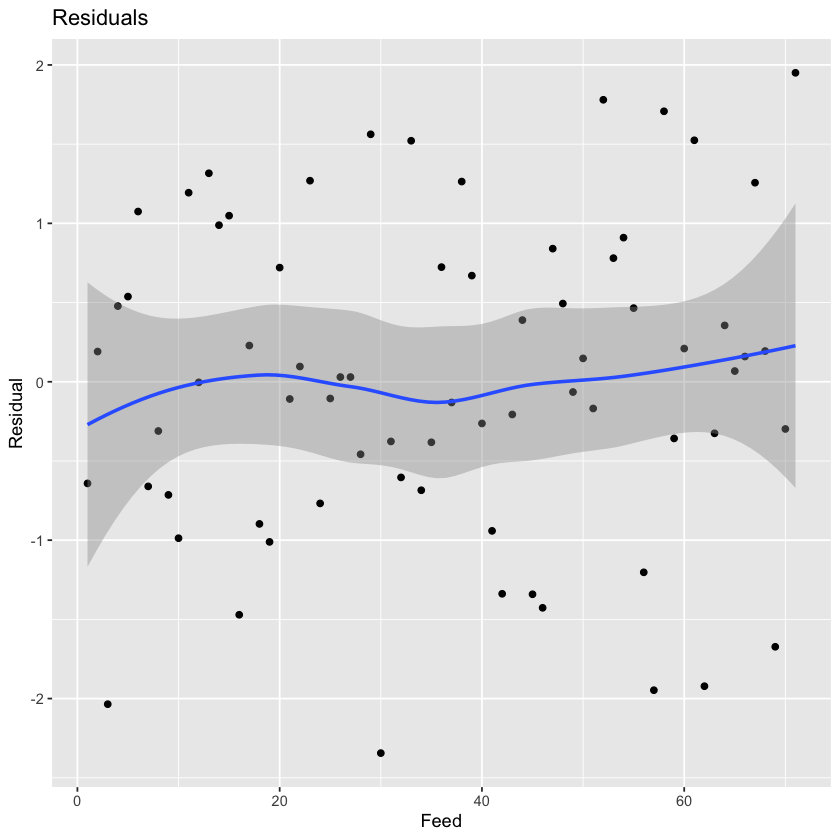

In [10]:
res = data$weight - mod.base$fitted.values
gg_resid(res, normalize=TRUE)

### Pooled Model

The pooled model assumes that each observation $i$ from group $j$ comes from the same distribution:

$$ Weight_{ij} \sim Normal(\mu, \sigma) $$

This model estimates an overall mean $\mu$ of approximately 261 and standard deviation $\sigma$ of approximately 77.

Penalized deviance: 823.2 

Convergence looks fine, but the residuals show some trend. When plotted by feed name, it's evident that the pooled model is inappropriate.

In [11]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(mu, prec)
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec ~ dexp(1)
  sigma = sqrt(1/prec)
} "

set.seed(43)
data_jags = as.list(data)
params = c("mu", "sigma")

mod.pooled = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed" in data”
Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 2
   Total graph size: 79

Initializing model



#### Results

In [12]:
summary(mod.pooled$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean    SD Naive SE Time-series SE
mu    261.38 9.315  0.07605        0.07432
sigma  77.86 6.559  0.05356        0.05321

2. Quantiles for each variable:

        2.5%    25%    50%    75%  97.5%
mu    243.04 255.20 261.43 267.55 279.70
sigma  66.51  73.24  77.43  81.99  91.97


In [13]:
round(mod.pooled$coefs, 4)

mu    sigma 
261.3810  77.8606

In [14]:
(dic.pooled = dic.samples(mod.pooled$obj, n.iter=1e3))

Mean deviance:  821.3 
penalty 1.969 
Penalized deviance: 823.3 

#### Convergence

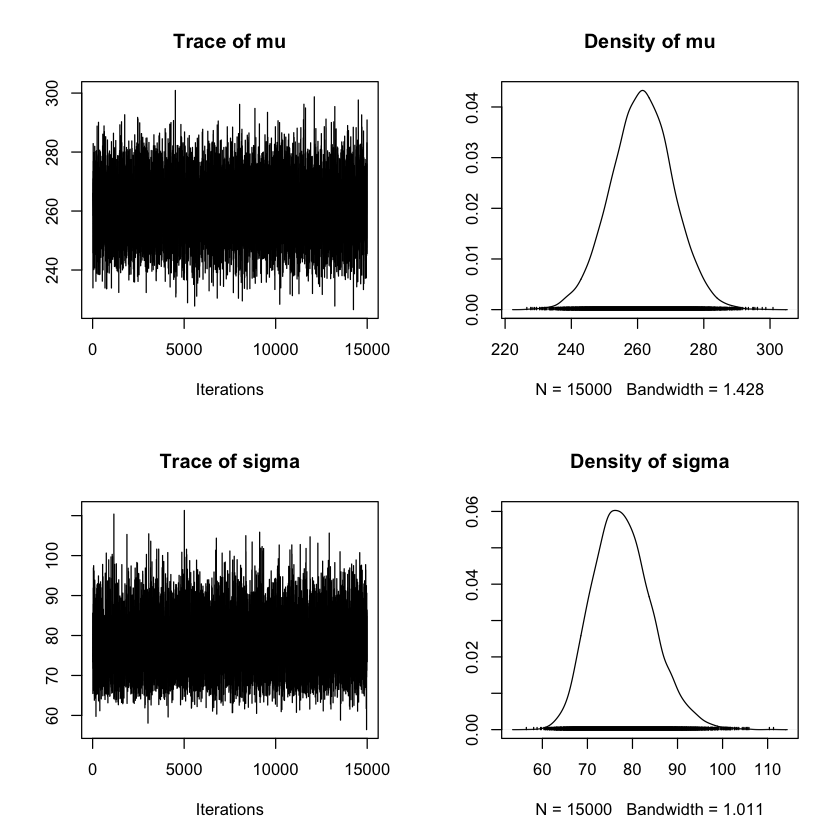

In [15]:
plot(mod.pooled$csim)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



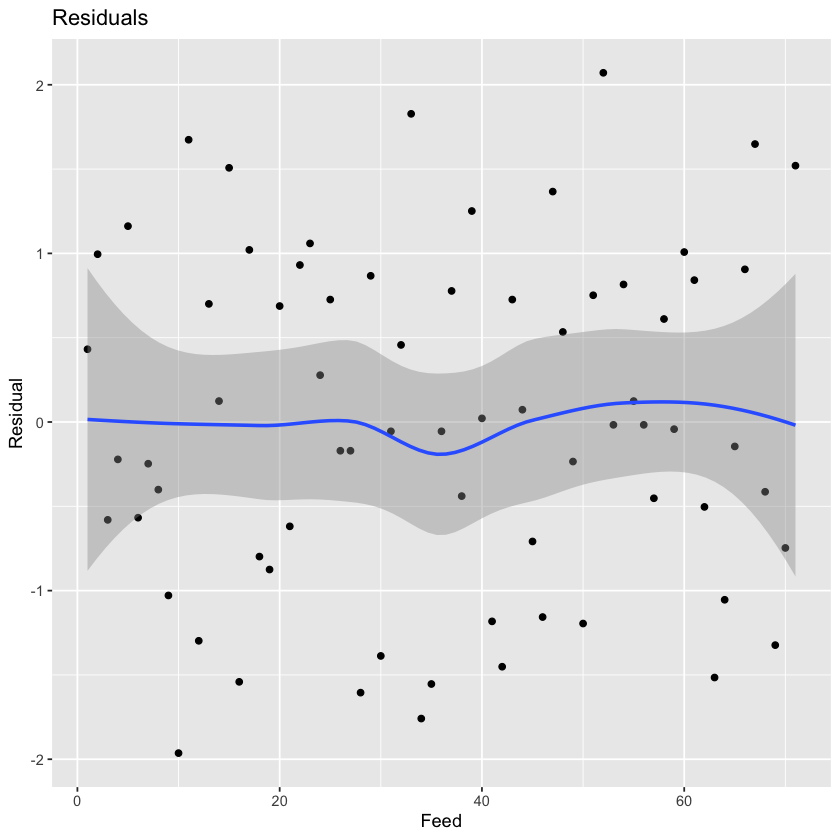

In [16]:
res = data$weight - mod.pooled$coefs[1]
gg_resid(res, normalize=TRUE)

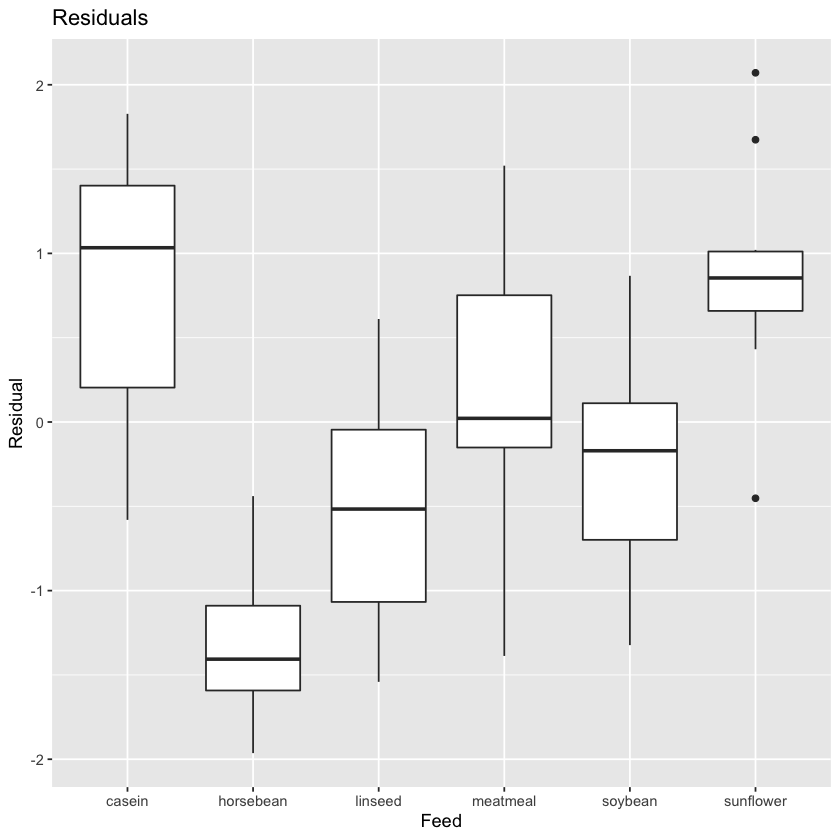

In [17]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

## Hierarchical Model

### Homogenous Variance

The pooled model assumes that each group mean $\theta_j$ comes from a separate distribution, but share a common variance $\sigma^2$. It also assumes that $\theta_j$ shares a prior distribution: 


$$ Weight_{ij} \sim Normal(\theta_j, \sigma) $$

$$ \theta_j \sim Normal(\mu, \tau) $$


This model estimates an overall mean $\mu$ of approximately 261 and standard deviation $\sigma$ of approximately 77.


This model estimates an overall mean $\mu$ of approximately 258.8871 and standard deviation $\sigma$ of approximately 54.8379. Estimates for mean $\theta_{1 \dots j}$ parameters are: \[317.4984, 170.3849, 222.3934, 275.2269, 247.3577, 322.5068\].

Penalized deviance: 778.5 

Convergence looks fine, and the residuals show no trend. When plotted by feed name, we see each group centered around zero.

In [18]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma)
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu, prec.tau)
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec.tau ~ dexp(1)
  prec.sigma ~ dexp(1)
  tau = sqrt(1/prec.tau)
  sigma = sqrt(1/prec.sigma)
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "mu", "sigma")

mod.hier = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 9
   Total graph size: 159

Initializing model



#### Results

In [19]:
summary(mod.hier$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean     SD Naive SE Time-series SE
mu       259.1 25.221  0.20593        0.22183
sigma     54.8  4.851  0.03961        0.04391
theta[1] 317.7 15.525  0.12676        0.13365
theta[2] 170.9 17.486  0.14277        0.17115
theta[3] 222.5 15.474  0.12634        0.13088
theta[4] 275.1 15.829  0.12924        0.13323
theta[5] 247.4 14.070  0.11488        0.11671
theta[6] 322.6 15.781  0.12885        0.13931

2. Quantiles for each variable:

           2.5%    25%    50%    75%  97.5%
mu       208.21 244.13 259.08 274.11 309.83
sigma     46.27  51.38  54.44  57.87  65.37
theta[1] 287.08 307.20 317.75 328.04 348.31
theta[2] 136.78 159.16 170.80 182.53 205.46
theta[3] 192.16 212.23 222.52 232.79 252.92
theta[4] 243.53 264.68 275.05 285.60 306.10
theta[5] 219.66 237.94 247.53 256.86 275.10
the

In [20]:
round(mod.hier$coefs, 4)

mu    sigma theta[1] theta[2] theta[3] theta[4] theta[5] theta[6] 
259.0721  54.7990 317.7152 170.8813 222.5309 275.0633 247.3791 322.5878

In [21]:
(dic.hier = dic.samples(mod.hier$obj, n.iter=1e3))

Mean deviance:  771.6 
penalty 6.958 
Penalized deviance: 778.6 

#### Convergence

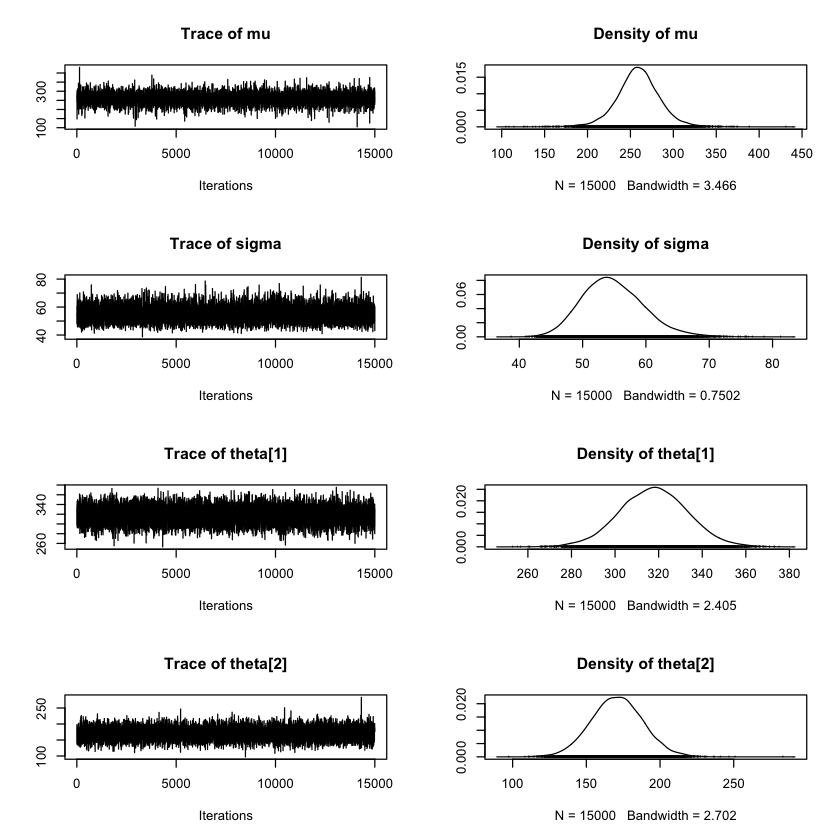

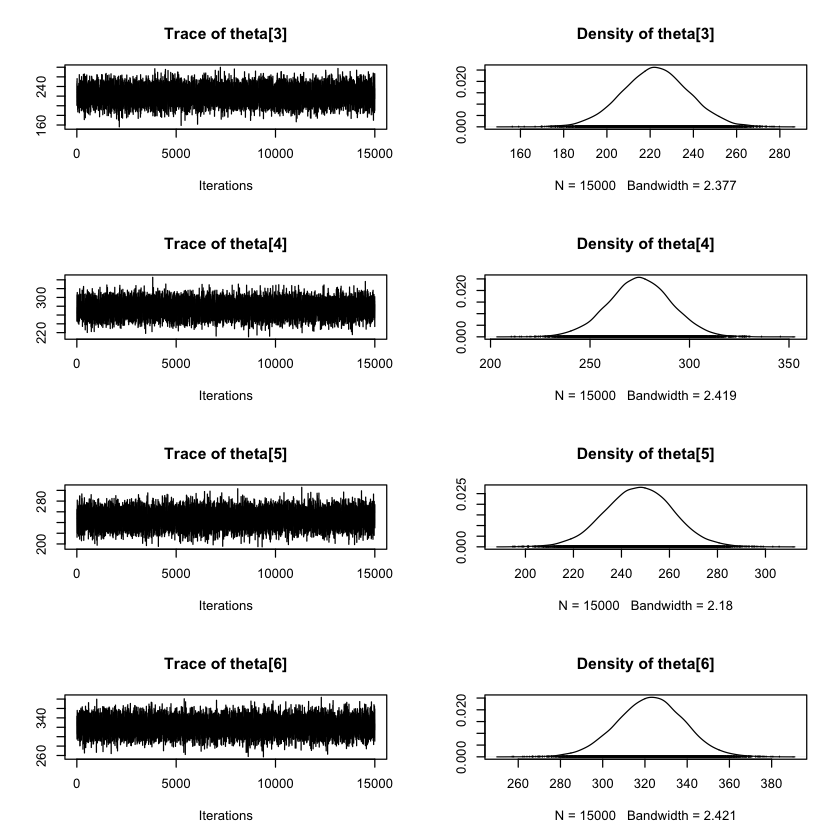

In [22]:
plot(mod.hier$csim, ask=FALSE)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



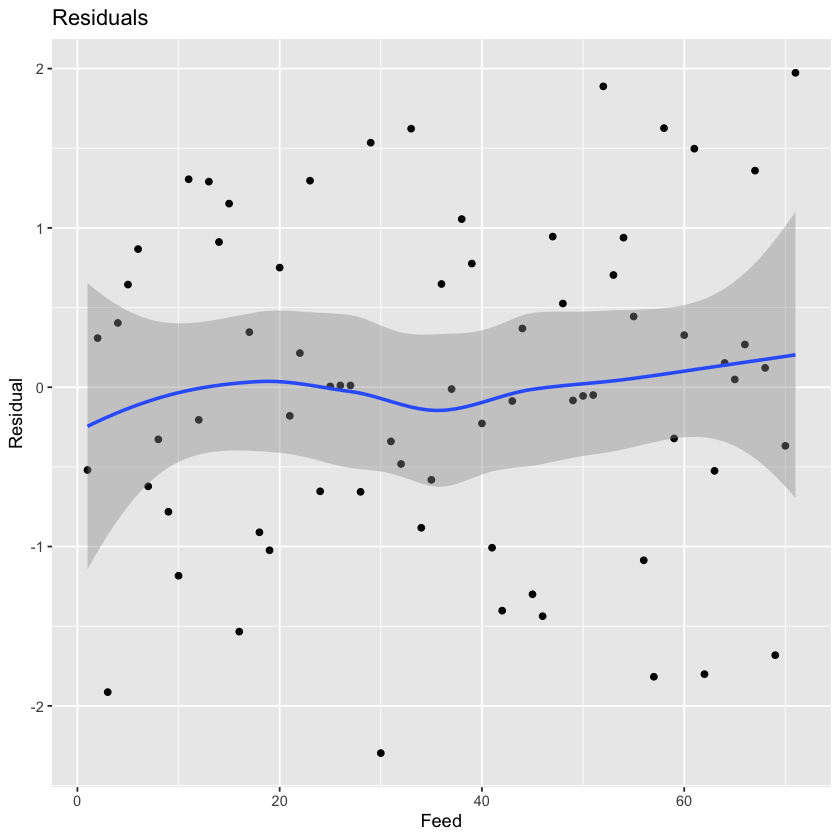

In [23]:
res = data$weight - mod.hier$coefs[3:8][data$feed]
gg_resid(res, normalize=TRUE)

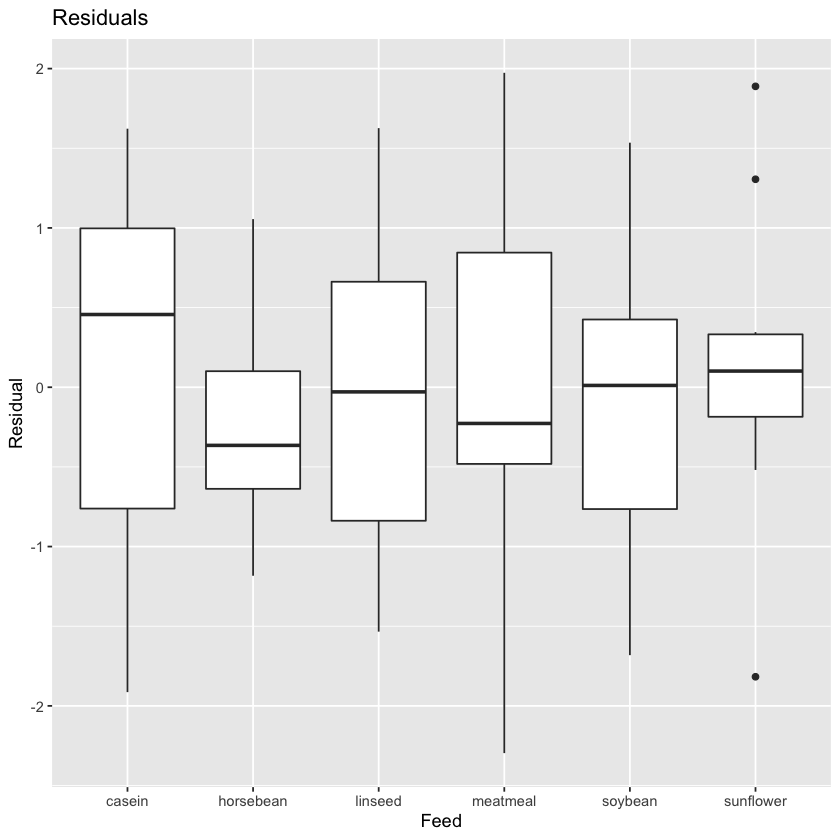

In [24]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

### Heterogenous Variance


The pooled model assumes that each group mean $\theta_j$ and variance $\sigma^2$ come from separate distributions. It also assumes that $\theta_j$ and $\sigma_j$ each share a prior distribution: 


$$ Weight_{ij} \sim Normal(\theta_j, \sigma_j) $$

$$ \theta_j \sim Normal(\mu, \tau) $$

$$ \frac{1}{\sigma^2_j} \sim Exp(1) $$


This model estimates an overall mean $\mu$ of approximately 261 and standard deviation $\sigma$ of approximately 77.


This model estimates an overall mean $\mu$ of approximately 258.0694. Estimates for mean $\theta_{1 \dots j}$ parameters are: \[316.3469, 165.6013, 221.3979, 274.6762, 247.0059, 324.0416\]. Estimates for standard deviation $\sigma_{1 \dots j}$ are: \[63.0679, 38.1755, 51.1029, 63.0624, 52.893, 47.9474\].

Penalized deviance: 785.4 is slightly higher than the pooled model with homogenous variance.

Convergence looks fine, and the residuals show no trend. When plotted by feed name, we see each group centered around zero.

In [25]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma[feed[i]])
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu, prec.tau)
    prec.sigma[j] ~ dexp(1)
    sigma[j] = sqrt(1/prec.sigma[j])
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec.tau ~ dexp(1)
  tau = sqrt(1/prec.tau)
  
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "mu", "sigma")

mod.hier.var.het = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 14
   Total graph size: 174

Initializing model



#### Results

In [26]:
summary(mod.hier.var.het$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD Naive SE Time-series SE
mu       258.20 26.368  0.21529        0.22850
sigma[1]  63.29 13.646  0.11142        0.12232
sigma[2]  38.07  9.578  0.07821        0.09304
sigma[3]  51.02 11.061  0.09031        0.09724
sigma[4]  62.87 14.058  0.11478        0.12604
sigma[5]  52.98 10.386  0.08480        0.08582
sigma[6]  47.94 10.417  0.08506        0.09212
theta[1] 316.12 18.244  0.14896        0.16686
theta[2] 165.50 12.899  0.10532        0.12255
theta[3] 221.88 14.651  0.11962        0.12506
theta[4] 274.52 17.987  0.14686        0.15175
theta[5] 247.22 13.877  0.11331        0.11422
theta[6] 324.02 14.121  0.11530        0.12769

2. Quantiles for each variable:

           2.5%    25%    50%    75%  97.5%
mu       206.58 242.48 258.05 273.71 309.80
sigma[1]  43.26  53.70 

In [27]:
round(mod.hier.var.het$coefs, 4)

mu sigma[1] sigma[2] sigma[3] sigma[4] sigma[5] sigma[6] theta[1] 
258.1991  63.2918  38.0733  51.0238  62.8655  52.9830  47.9434 316.1233 
theta[2] theta[3] theta[4] theta[5] theta[6] 
165.4963 221.8797 274.5215 247.2154 324.0242

In [28]:
(dic.hier.var.het = dic.samples(mod.hier.var.het$obj, n.iter=1e3))

Mean deviance:  772.3 
penalty 12.96 
Penalized deviance: 785.2 

#### Convergence

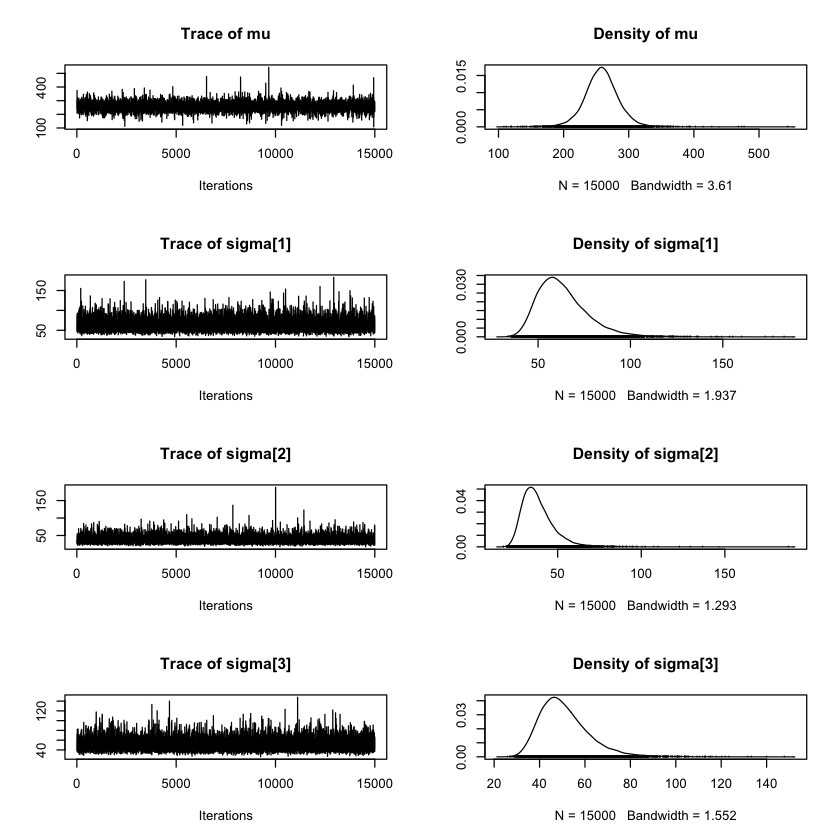

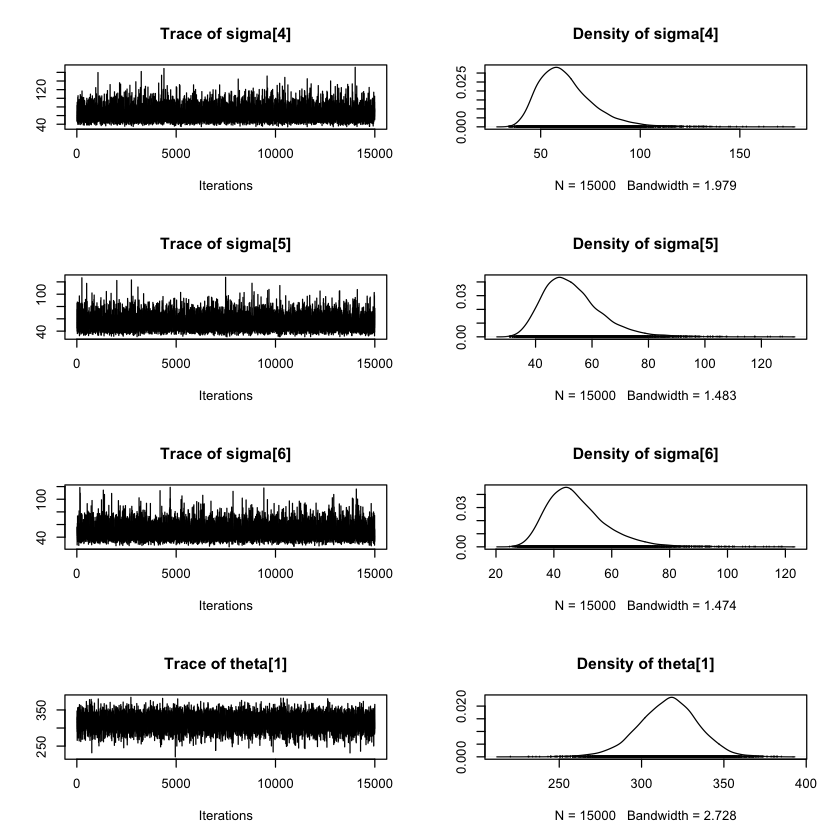

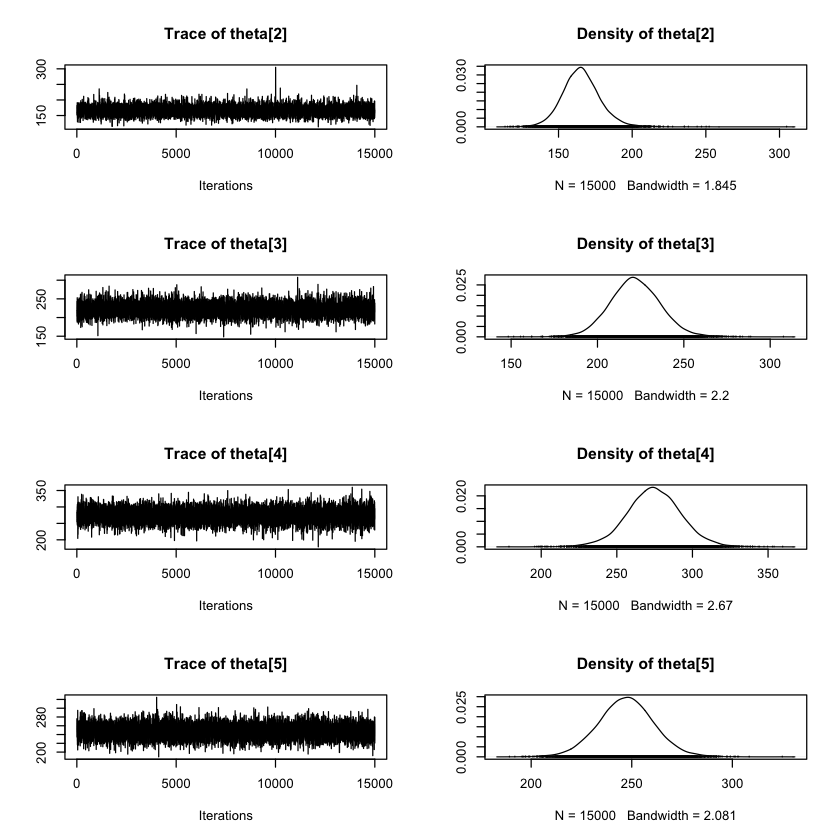

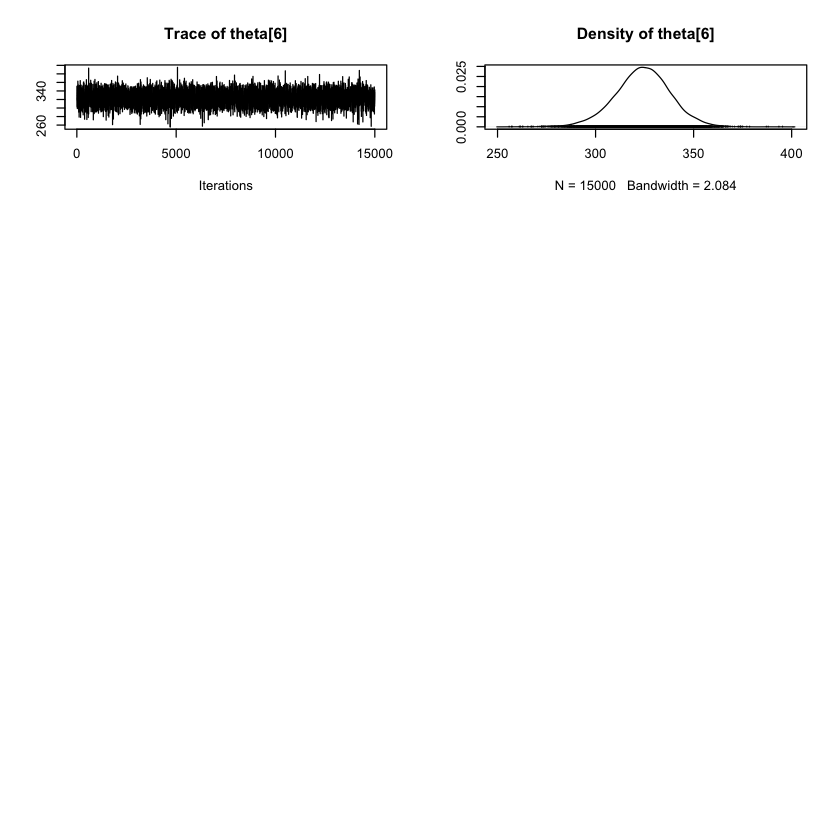

In [29]:
plot(mod.hier.var.het$csim, ask=FALSE)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



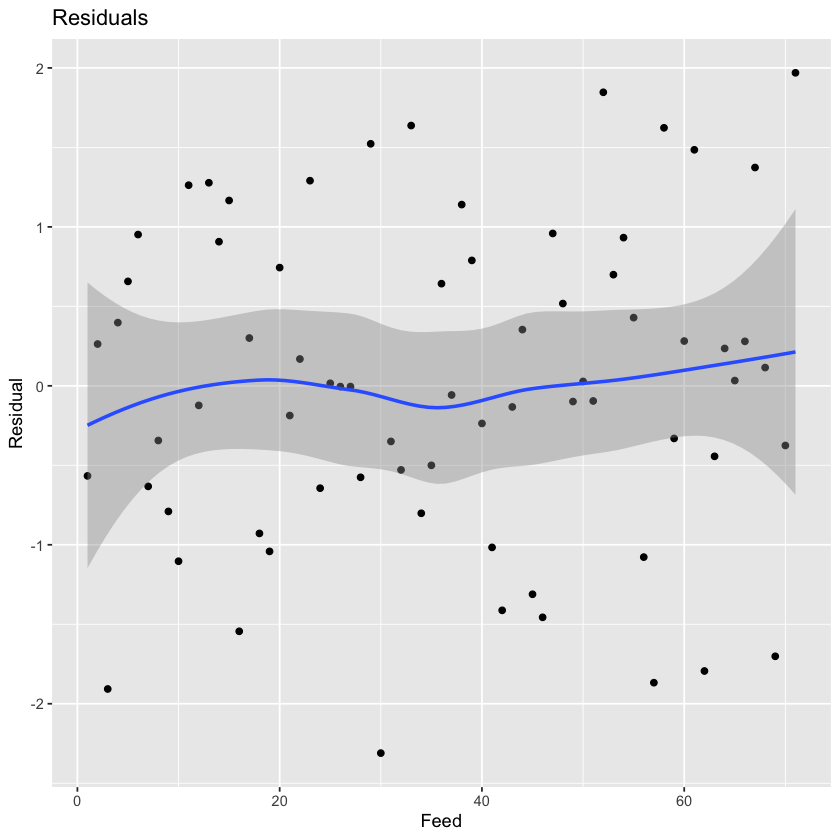

In [30]:
res = data$weight - mod.hier.var.het$coefs[8:13][data$feed]
gg_resid(res, normalize=TRUE)

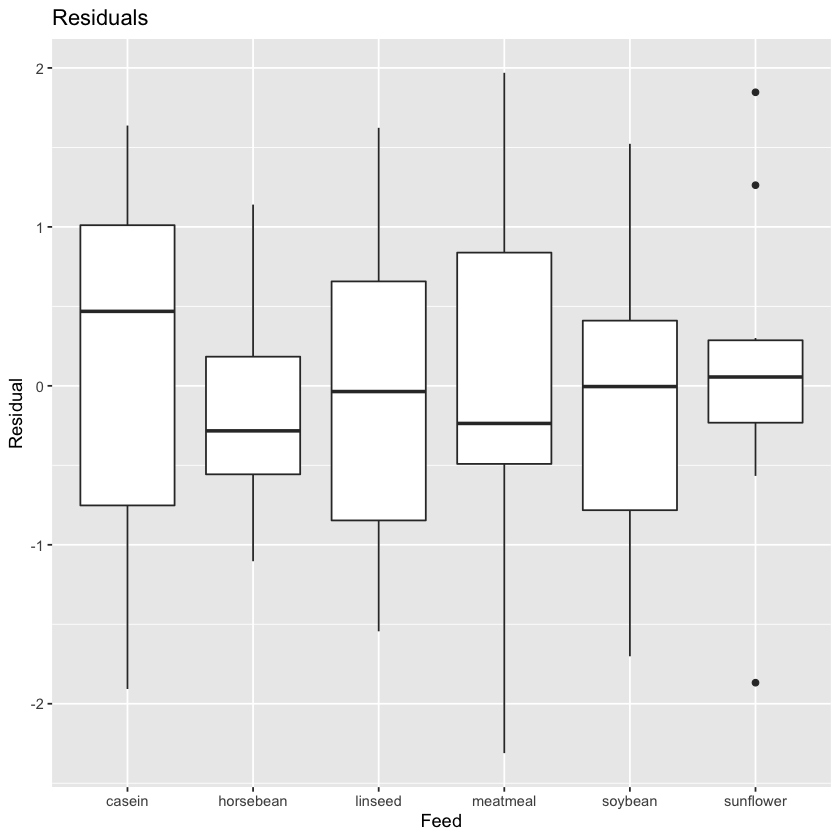

In [31]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

## Heterogenous Model

The pooled model assumes that each group mean $\theta_j$ comes from a separate distribution, but share a common variance $\sigma^2$. It also assumes that each $\theta_j$ comes from a separate prior distribution: 


$$ Weight_{ij} \sim Normal(\theta_j, \sigma) $$

$$ \theta_j \sim Normal(\mu_j, \tau_j) $$


This model estimates an overall mean $\mu$ of approximately 261 and standard deviation $\sigma$ of approximately 77.


This model estimates very similar parameters for the standard deviation of priors $\tau_j$. Estimates for mean $\theta_{1 \dots j}$ parameters are: \[323.4463, 159.3786, 218.6452, 276.5362, 246.7235, 328.2184\].

Penalized deviance: 780.7 is slightly higher than the pooled model with homogenous variance.

We increase sample size (per chain) to 50,000 to improve convergence; the residuals show no trend. When plotted by feed name, we see each group centered around zero.

In [32]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma)
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu[j], prec.tau[j])
    mu[j] ~ dnorm(0, 1.0/1.0e6)
    prec.tau[j] ~ dexp(1)
    tau[j] = sqrt(1/prec.tau[j])
  }
  
  prec.sigma ~ dexp(1)
  sigma = sqrt(1/prec.sigma)
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "tau")

mod.het = run_sim(
    model.str = mod_string,
    data = data_jags,
    params = params,
    burn_in=5e3,
    n_iter=5e4
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 19
   Total graph size: 179

Initializing model



#### Results

In [33]:
summary(mod.het$sim)


Iterations = 5001:55000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean     SD Naive SE Time-series SE
tau[1]     1.766  3.731 0.009635        0.01861
tau[2]     1.780  3.964 0.010236        0.02060
tau[3]     1.778  2.915 0.007527        0.01453
tau[4]     1.761  2.756 0.007117        0.01290
tau[5]     1.751  2.543 0.006567        0.01206
tau[6]     1.776  3.363 0.008684        0.01734
theta[1] 323.521 16.262 0.041989        0.46851
theta[2] 159.765 17.328 0.044742        0.52387
theta[3] 218.531 16.315 0.042124        0.46446
theta[4] 276.614 17.044 0.044008        0.49875
theta[5] 246.344 14.824 0.038276        0.39664
theta[6] 328.699 15.636 0.040372        0.42749

2. Quantiles for each variable:

             2.5%      25%     50%     75%   97.5%
tau[1]     0.5188   0.8493   1.202   1.862   6.189
tau[2]     0.5208   0.8480   1.201   1.85

In [34]:
round(mod.het$coefs, 4)

tau[1]   tau[2]   tau[3]   tau[4]   tau[5]   tau[6] theta[1] theta[2] 
  1.7661   1.7799   1.7777   1.7609   1.7506   1.7762 323.5205 159.7651 
theta[3] theta[4] theta[5] theta[6] 
218.5312 276.6140 246.3443 328.6994

In [35]:
(dic.het = dic.samples(mod.het$obj, n.iter=1e3))

Mean deviance:  771.3 
penalty 7.737 
Penalized deviance: 779.1 

#### Convergence

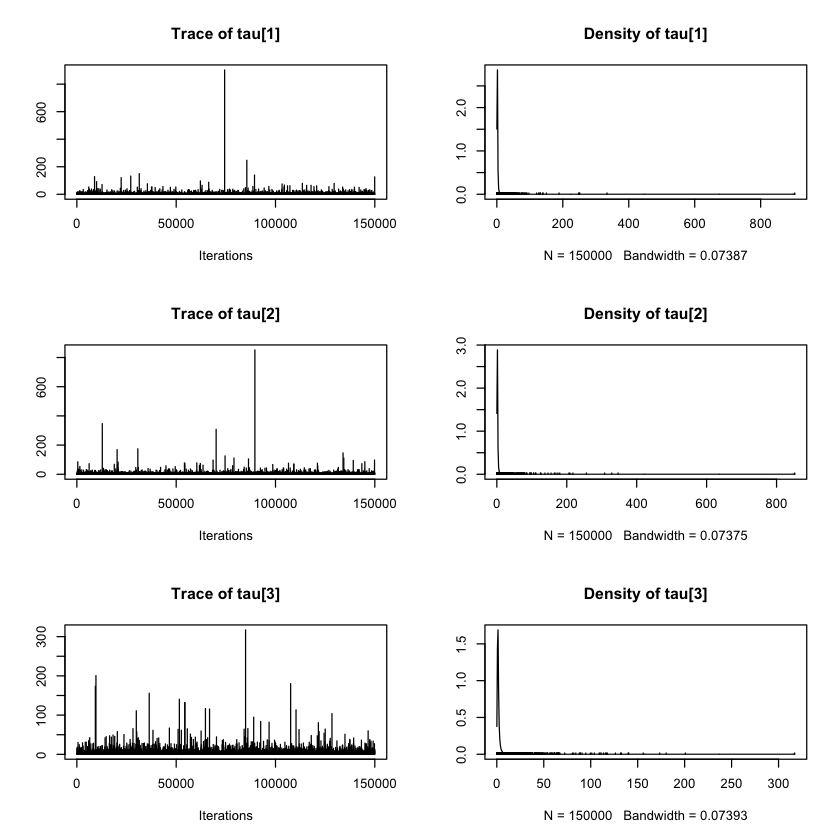

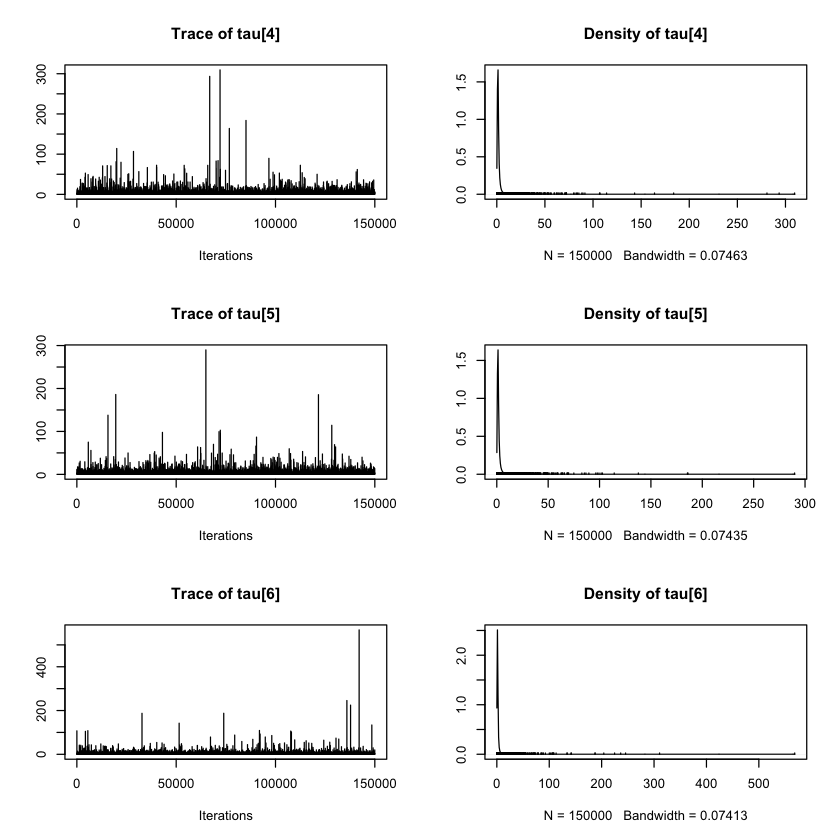

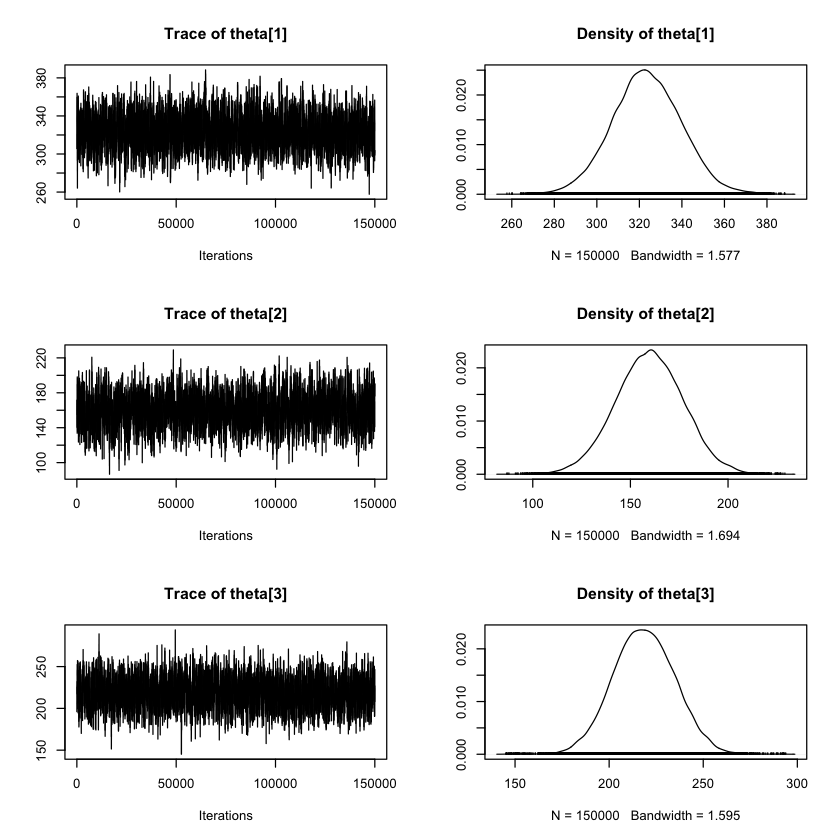

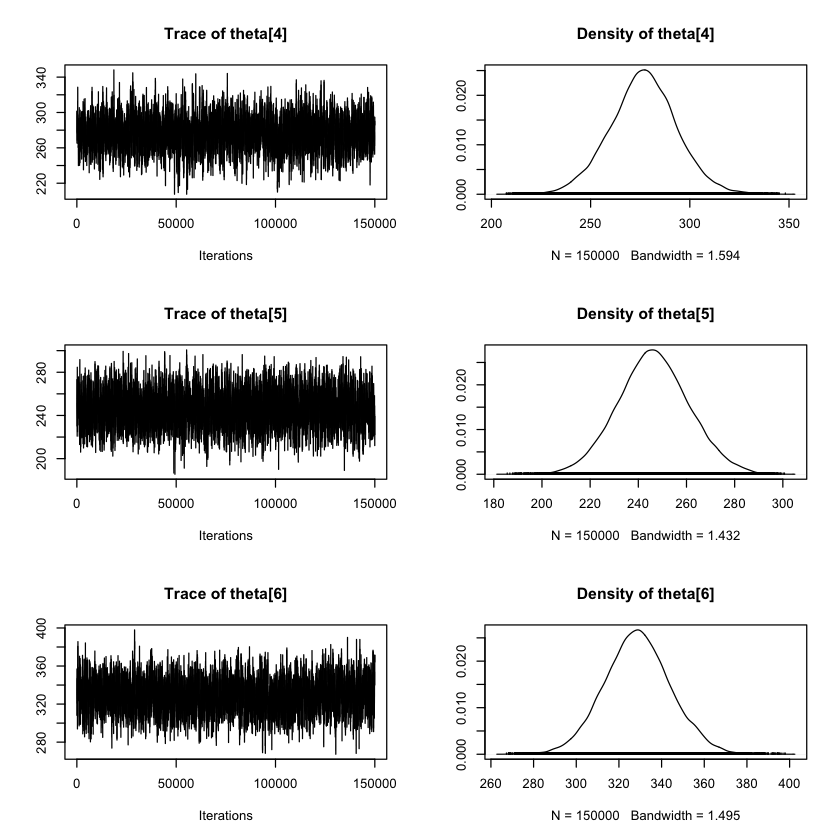

In [36]:
plot(mod.het$csim, ask=FALSE)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



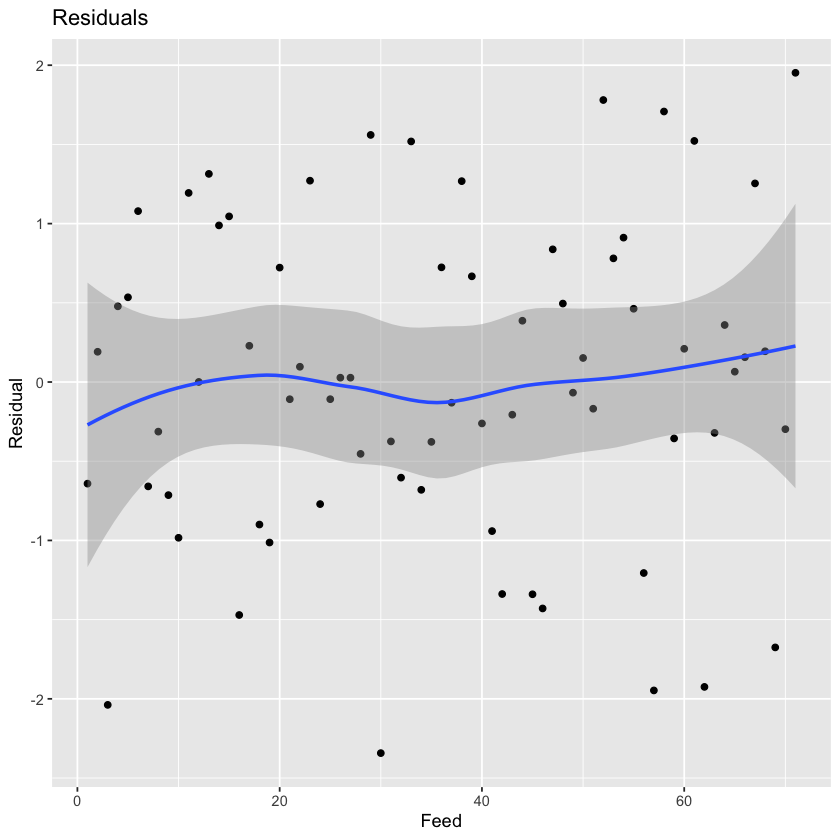

In [37]:
res = data$weight - mod.het$coefs[7:12][data$feed]
gg_resid(res, normalize=TRUE)

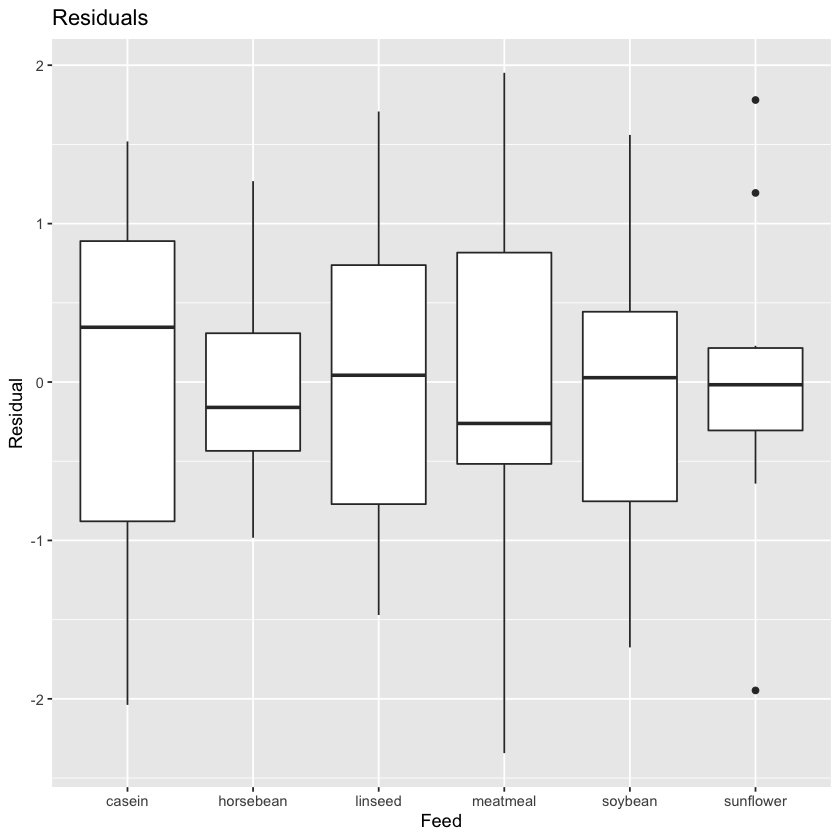

In [38]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

### Comparing Parameters

In [39]:
tibble(
    "Base"=round(coef(mod.base), 4),
    "Hierarchical"=round(mod.hier$coefs[3:8], 4),
    "Hierarchical, Het Var"=round(mod.hier.var.het$coefs[8:13], 4),
    "Heterogenous"=round(mod.het$coefs[7:12], 4)
    )


Base,Hierarchical,"Hierarchical, Het Var",Heterogenous
<dbl>,<dbl>,<dbl>,<dbl>
323.5833,317.7152,316.1233,323.5205
160.2000,170.8813,165.4963,159.7651
218.7500,222.5309,221.8797,218.5312
276.9091,275.0633,274.5215,276.6140
246.4286,247.3791,247.2154,246.3443
328.9167,322.5878,324.0242,328.6994


## Posterior Analysis

### Posterior Distributions of Theta

In [40]:
set.seed(43)
N = 1e4
post.dist = list()
for (i in 1:6) {
    col = glue("theta[{i}]")
    theta.post = sample(mod.hier$csim[, col], N, replace = TRUE)
    sigma.post = sample(mod.hier$csim[, "sigma"], N, replace = TRUE)
    z = rnorm(N, mean=theta.post, sd=sigma.post)
    post.dist[[col]] = z
}

post.dist = as_tibble(post.dist)

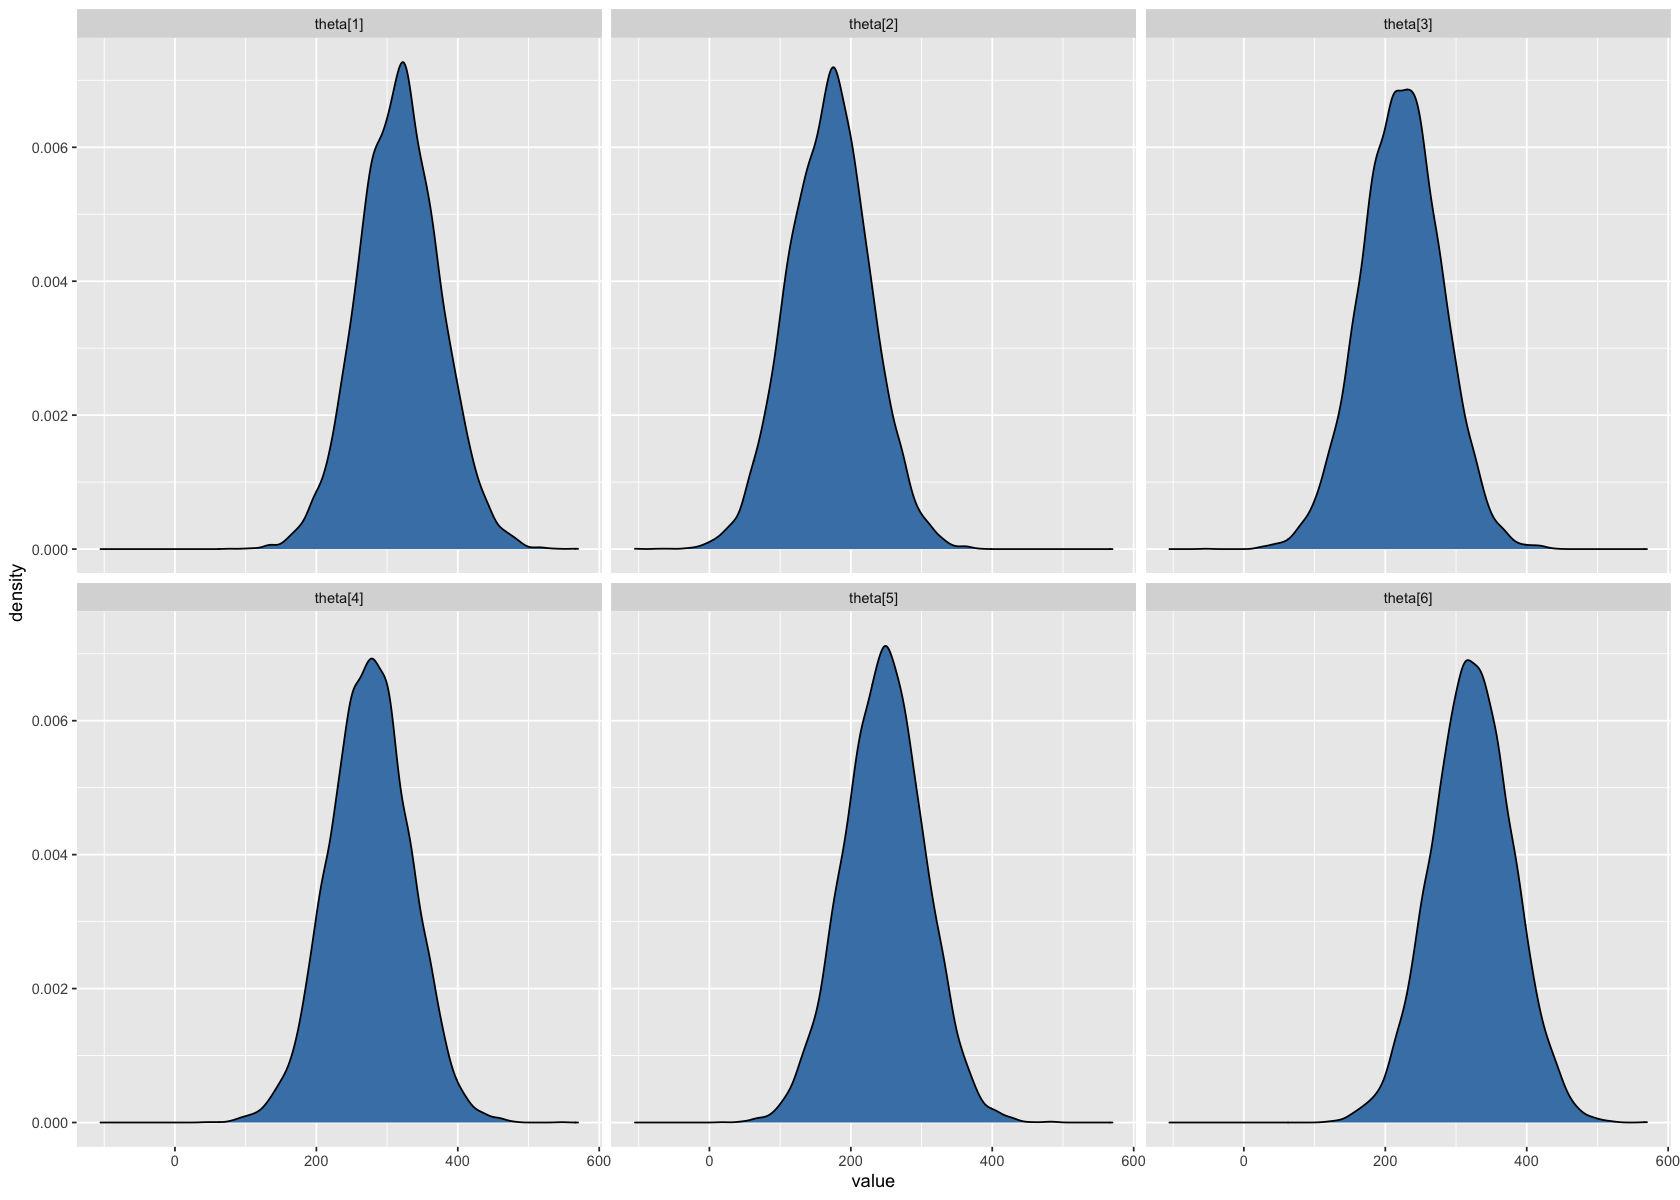

In [41]:
default_options = options()
options(repr.plot.width=14, repr.plot.height=10)

post.dist %>%
    pivot_longer(everything()) %>%
    ggplot(aes(x=value)) +
    geom_density(fill="steelblue") +
    facet_wrap(~name)
    

### Answers to Questions

In [42]:
post.dist %>% colMeans()

theta[1] theta[2] theta[3] theta[4] theta[5] theta[6] 
317.1553 169.2642 222.4533 275.3234 247.0156 322.3615

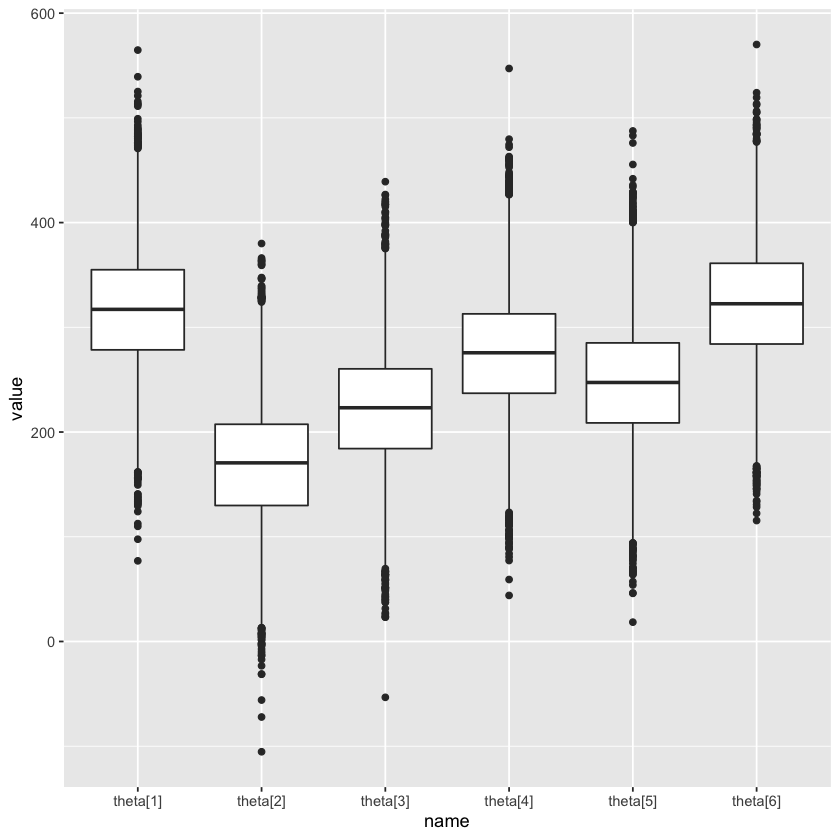

In [45]:
options(default_options)

post.dist %>%
    pivot_longer(everything()) %>%
    ggplot(aes(x=name, y=value, group=name)) +
    geom_boxplot()

In [46]:
feeds = levels(data$feed_name)
for (i in 1:5) {
    prob = mean(post.dist[, "theta[6]"] > post.dist[, glue("theta[{i}]")])
    print(glue("Probability that {feeds[6]} > {feeds[i]}: {prob}"))
    }

Probability that sunflower > casein: 0.5246
Probability that sunflower > horsebean: 0.973
Probability that sunflower > linseed: 0.8925
Probability that sunflower > meatmeal: 0.718
Probability that sunflower > soybean: 0.826
